<a href="https://colab.research.google.com/github/cs20m016/cs6910-Assignment-3/blob/main/BestModel_Rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
!unzip /content/drive/MyDrive/lexicons.zip > /dev/null

In [37]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import random
from keras.utils.vis_utils import plot_model
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RNN, GRU, SimpleRNN
import math
from math import log
import pandas as pd

In [5]:
# Path to the data txt file on disk.
data_path = "/content/lexicons/hi.translit.sampled.train.tsv"
val_path = "/content/lexicons/hi.translit.sampled.dev.tsv"
test_path = "/content/lexicons/hi.translit.sampled.test.tsv"

input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

input_characters.add(" ")
target_characters.add(" ")
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

val_input_texts = []
val_target_texts = []

with open(val_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    val_input_texts.append(input_text)
    val_target_texts.append(target_text)

test_input_texts = []
test_target_texts = []

with open(test_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
for line in lines[: len(lines) - 1]:
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    test_input_texts.append(input_text)
    test_target_texts.append(target_text)

print("Number of samples:", len(input_texts))
print("Number of validation samples:", len(val_input_texts))
print("Number of test samples:", len(test_input_texts))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

Number of samples: 44204
Number of validation samples: 4358
Number of test samples: 4502
Number of unique input tokens: 27
Number of unique output tokens: 66
Max sequence length for inputs: 20
Max sequence length for outputs: 21


In [6]:
print("Train Set Samples")
for i in range (5):
  index = random. randint(0,len(target_texts))
  print(input_texts[index],target_texts[index])

Train Set Samples
kaya 	काया

yajman 	यजमान

eliot 	इलियट

lutna 	लूटना

presidents 	प्रेसिडेंट्स



In [9]:
print("Test Set Samples")
for i in range (5):
  index = random. randint(0,len(test_target_texts))
  print(test_input_texts[index],test_target_texts[index],'\n')

Test Set Samples
greg ग्रेग 

safety सेफ्टी 

thumari ठुमरी 

haldi हल्दी 

watanukoollan वातानुकूलन 



In [10]:
input_token_index = dict([(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict([(char, i) for i, char in enumerate(target_characters)])

encoder_input_data = np.zeros((len(input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
decoder_input_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
decoder_target_data = np.zeros((len(input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
print(np.shape(encoder_input_data),np.shape(decoder_input_data),np.shape(decoder_target_data))

val_encoder_input_data = np.zeros((len(val_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
val_decoder_input_data = np.zeros((len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
val_decoder_target_data = np.zeros((len(val_input_texts), max_decoder_seq_length, num_decoder_tokens), dtype="float32")
print(np.shape(val_encoder_input_data),np.shape(val_decoder_input_data),np.shape(val_decoder_target_data))

test_encoder_input_data = np.zeros((len(test_input_texts), max_encoder_seq_length, num_encoder_tokens), dtype="float32")
print(np.shape(test_encoder_input_data))

for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

for i, (val_input_text, val_target_text) in enumerate(zip(val_input_texts, val_target_texts)):
    for t, char in enumerate(val_input_text):
        val_encoder_input_data[i, t, input_token_index[char]] = 1.0
    val_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(val_target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        val_decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            val_decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    val_decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    val_decoder_target_data[i, t:, target_token_index[" "]] = 1.0

for i, (test_input_text, ) in enumerate(zip(test_input_texts, )):
    for t, char in enumerate(test_input_text):
        test_encoder_input_data[i, t, input_token_index[char]] = 1.0
    test_encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

(44204, 20, 27) (44204, 21, 66) (44204, 21, 66)
(4358, 20, 27) (4358, 21, 66) (4358, 21, 66)
(4502, 20, 27)


In [11]:
batch_size = 32  # Batch size for training.
epochs = 10  # Number of epochs to train for.
layers = 3
hidden_neurons = 126
dropout = 0.1
recc_dropout = 0.0

In [12]:
#latent_dims = [256,128,64]  # Latent dimensionality of the encoding space.
latent_dims = []
for i in range(layers):
  latent_dims.append((i+1)*hidden_neurons)
latent_dims = latent_dims[::-1]
print(latent_dims)

[378, 252, 126]


In [13]:
def LSTM_model():
  # Define an input sequence and process it by going through a len(latent_dims)-layer deep encoder
  encoder_inputs = Input(shape=(None, num_encoder_tokens))

  outputs = encoder_inputs
  encoder_states = []
  for j in range(len(latent_dims))[::-1]:
      outputs, h, c = LSTM(latent_dims[j], return_state=True, return_sequences=bool(j))(outputs)
      encoder_states += [h, c]

  # Set up the decoder, setting the initial state of each layer to the state of the layer in the encoder
  # which is it's mirror (so for encoder: a->b->c, you'd have decoder initial states: c->b->a).
  decoder_inputs = Input(shape=(None, num_decoder_tokens))

  outputs = decoder_inputs
  output_layers = []
  for j in range(len(latent_dims)):
      output_layers.append(LSTM(latent_dims[len(latent_dims) - j - 1], return_sequences=True, return_state=True))
      outputs, dh, dc = output_layers[-1](outputs, initial_state=encoder_states[2*j:2*(j+1)])


  decoder_dense = Dense(num_decoder_tokens, activation='softmax')
  decoder_outputs = decoder_dense(outputs)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
  model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_data=([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data))
  encoder_model = Model(encoder_inputs, encoder_states)

  d_outputs = decoder_inputs
  decoder_states_inputs = []
  decoder_states = []
  for j in range(len(latent_dims))[::-1]:
      current_state_inputs = [Input(shape=(latent_dims[j],)) for _ in range(2)]
      temp = output_layers[len(latent_dims)-j-1](d_outputs, initial_state=current_state_inputs)
      d_outputs, cur_states = temp[0], temp[1:]

      decoder_states += cur_states
      decoder_states_inputs += current_state_inputs

  decoder_outputs = decoder_dense(d_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  return model,encoder_model,decoder_model

In [14]:
def GRU_model():
  # Define an input sequence and process it by going through a len(latent_dims)-layer deep encoder
  encoder_inputs = Input(shape=(None, num_encoder_tokens))

  outputs = encoder_inputs
  encoder_states = []
  for j in range(len(latent_dims))[::-1]:
      outputs, h = GRU(latent_dims[j], return_state=True, return_sequences=bool(j))(outputs)
      encoder_states += [h]

  # Set up the decoder, setting the initial state of each layer to the state of the layer in the encoder
  # which is it's mirror (so for encoder: a->b->c, you'd have decoder initial states: c->b->a).
  decoder_inputs = Input(shape=(None, num_decoder_tokens))

  outputs = decoder_inputs
  output_layers = []
  for j in range(len(latent_dims)):
      output_layers.append(GRU(latent_dims[len(latent_dims) - j - 1], return_sequences=True, return_state=True))
      outputs, dh = output_layers[-1](outputs, initial_state=encoder_states[j:j+1])

  decoder_dense = Dense(num_decoder_tokens, activation='softmax')
  decoder_outputs = decoder_dense(outputs)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
  model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_data=([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data))
  encoder_model = Model(encoder_inputs, encoder_states)

  d_outputs = decoder_inputs
  decoder_states_inputs = []
  decoder_states = []
  for j in range(len(latent_dims))[::-1]:
      current_state_inputs = [Input(shape=(latent_dims[j],)) for _ in range(1)]
      temp = output_layers[len(latent_dims)-j-1](d_outputs, initial_state=current_state_inputs)
      d_outputs, cur_states = temp[0], temp[1:]

      decoder_states += cur_states
      decoder_states_inputs += current_state_inputs

  decoder_outputs = decoder_dense(d_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  return model,encoder_model,decoder_model

In [15]:
def RNN_model():
  # Define an input sequence and process it by going through a len(latent_dims)-layer deep encoder
  encoder_inputs = Input(shape=(None, num_encoder_tokens))

  outputs = encoder_inputs
  encoder_states = []
  for j in range(len(latent_dims))[::-1]:
      outputs, h = SimpleRNN(latent_dims[j], return_state=True, return_sequences=bool(j))(outputs)
      encoder_states += [h]

  # Set up the decoder, setting the initial state of each layer to the state of the layer in the encoder
  # which is it's mirror (so for encoder: a->b->c, you'd have decoder initial states: c->b->a).
  decoder_inputs = Input(shape=(None, num_decoder_tokens))

  outputs = decoder_inputs
  output_layers = []
  for j in range(len(latent_dims)):
      output_layers.append(SimpleRNN(latent_dims[len(latent_dims) - j - 1], return_sequences=True, return_state=True))
      outputs, dh = output_layers[-1](outputs, initial_state=encoder_states[j:j+1])

  decoder_dense = Dense(num_decoder_tokens, activation='softmax')
  decoder_outputs = decoder_dense(outputs)

  # Define the model that will turn
  # `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
  model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
  model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
  model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size=batch_size, epochs=epochs, validation_data=([val_encoder_input_data, val_decoder_input_data],val_decoder_target_data))
  encoder_model = Model(encoder_inputs, encoder_states)

  d_outputs = decoder_inputs
  decoder_states_inputs = []
  decoder_states = []
  for j in range(len(latent_dims))[::-1]:
      current_state_inputs = [Input(shape=(latent_dims[j],)) for _ in range(1)]
      temp = output_layers[len(latent_dims)-j-1](d_outputs, initial_state=current_state_inputs)
      d_outputs, cur_states = temp[0], temp[1:]

      decoder_states += cur_states
      decoder_states_inputs += current_state_inputs

  decoder_outputs = decoder_dense(d_outputs)
  decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)
  return model,encoder_model,decoder_model

Epoch 1/10
1382/1382 [==============================] - 74s 25ms/step - loss: 0.9075 - accuracy: 0.7615 - val_loss: 0.3112 - val_accuracy: 0.9037
Epoch 2/10
1382/1382 [==============================] - 32s 23ms/step - loss: 0.2551 - accuracy: 0.9208 - val_loss: 0.2048 - val_accuracy: 0.9361
Epoch 3/10
1382/1382 [==============================] - 33s 24ms/step - loss: 0.1516 - accuracy: 0.9522 - val_loss: 0.1782 - val_accuracy: 0.9457
Epoch 4/10
1382/1382 [==============================] - 32s 24ms/step - loss: 0.1092 - accuracy: 0.9658 - val_loss: 0.1727 - val_accuracy: 0.9472
Epoch 5/10
1382/1382 [==============================] - 33s 24ms/step - loss: 0.0833 - accuracy: 0.9735 - val_loss: 0.1729 - val_accuracy: 0.9496
Epoch 6/10
1382/1382 [==============================] - 33s 24ms/step - loss: 0.0654 - accuracy: 0.9793 - val_loss: 0.1833 - val_accuracy: 0.9470
Epoch 7/10
1382/1382 [==============================] - 33s 24ms/step - loss: 0.0541 - accuracy: 0.9828 - val_loss: 0.1785 -

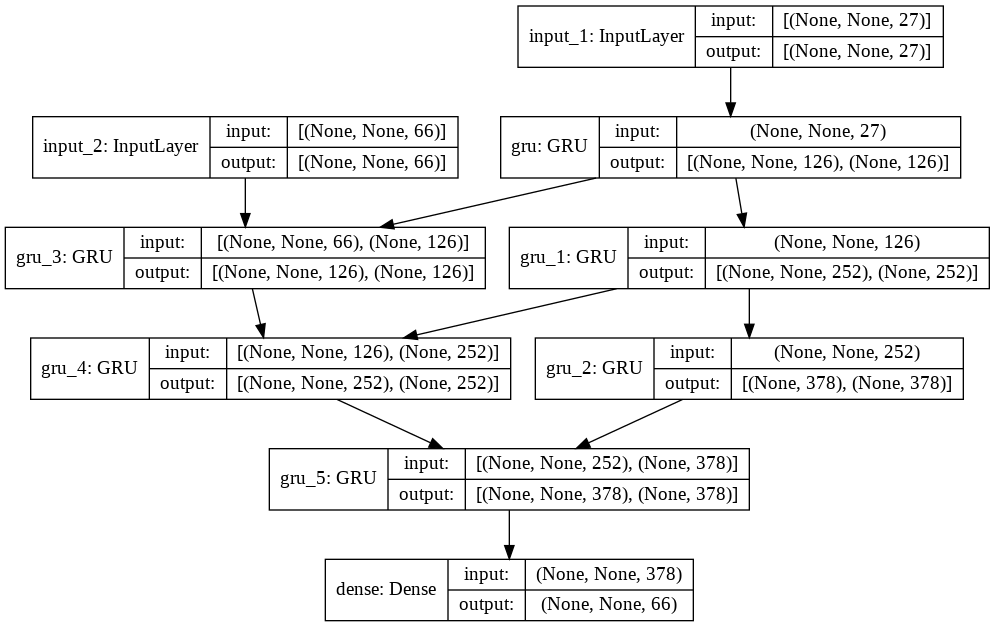

In [16]:
model,encoder_model,decoder_model = GRU_model()
plot_model(model, show_shapes=True)

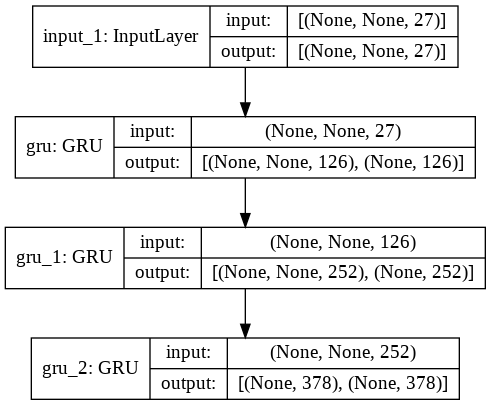

In [18]:
plot_model(encoder_model, show_shapes=True)

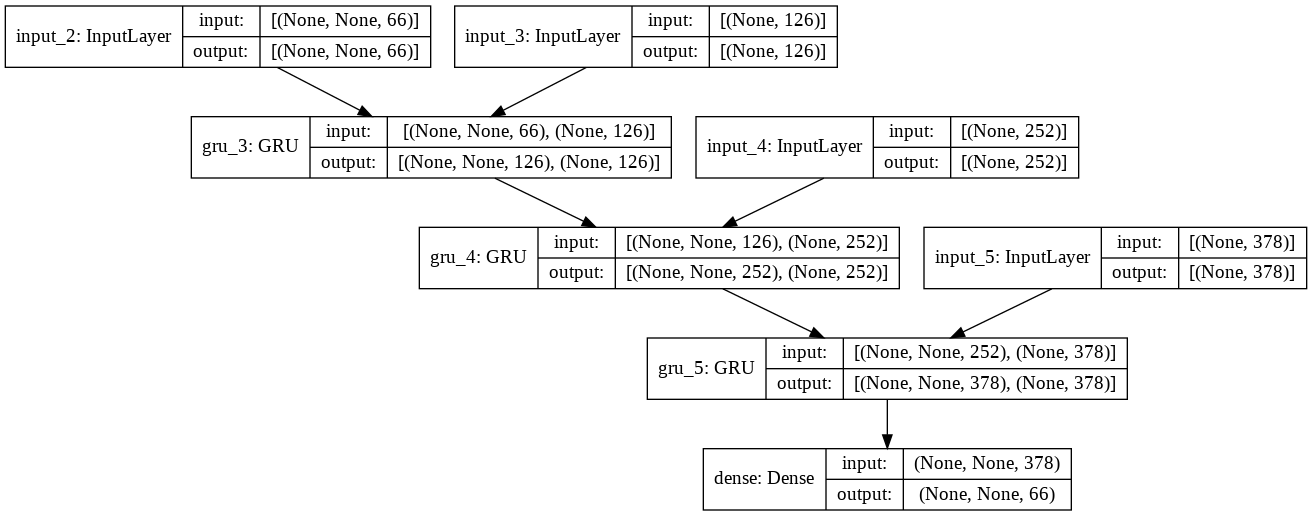

In [19]:
plot_model(decoder_model, show_shapes=True)

In [20]:
# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [21]:
def decode_sequence(input_seq,beam_search):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index['\t']] = 1.

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentences = []
    if beam_search==0:
      decoded_sentence = []  #Creating a list then using "".join() is usually much faster for string creation
      while not stop_condition:
          to_split = decoder_model.predict([target_seq] + states_value)
          output_tokens, states_value = to_split[0], to_split[1:]
          sampled_token_index = np.argmax(output_tokens[0, 0])
          sampled_char = reverse_target_char_index[sampled_token_index]
          decoded_sentence.append(sampled_char)
          if sampled_char == '\n' or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
      decoded_sentences.append("".join(decoded_sentence))
    else:
      decoded_prob = []
      it=0
      while not stop_condition:
          to_split = decoder_model.predict([target_seq] + states_value)
          output_tokens, states_value = to_split[0], to_split[1:]
          sampled_token_index = np.argmax(output_tokens[0, 0])
          sampled_char = reverse_target_char_index[sampled_token_index]
          it += 1
          decoded_prob.append(output_tokens[0, 0])
          if sampled_char == '\n' or it > max_decoder_seq_length:
            stop_condition = True
          target_seq = np.zeros((1, 1, num_decoder_tokens))
          target_seq[0, 0, sampled_token_index] = 1.
      sequences = [[list(), 0.0]]
      # walk over each step in sequence
      for row in decoded_prob:
        all_candidates = list()
        # expand each current candidate
        for i in range(len(sequences)):
          seq, score = sequences[i]
          for j in range(len(row)):
            candidate = [seq + [j], score - log(row[j])]
            all_candidates.append(candidate)
        # order all candidates by score
        ordered = sorted(all_candidates, key=lambda tup:tup[1])
        # select k best
        sequences = ordered[:beam_search]
      for seq in sequences:
        decoded_sentence = []
        for char_in in seq[0]:
          sampled_char = reverse_target_char_index[char_in]
          decoded_sentence.append(sampled_char)
        decoded_sentences.append("".join(decoded_sentence))
    return decoded_sentences

In [24]:
valid = 0
beam_search=5
samples=1000
for i in range(samples):
    # Take one sequence (part of the training set)
    # for trying out decoding.
    #seq_index=random.randint(0,len(test_input_texts))
    seq_index=i
    input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq,beam_search)
    #print("-")
    #print("Input sentence:", test_input_texts[seq_index])
    #for seq in decoded_sentence:
      #print("Decoded sentence:", seq)
    #print("Actual sentence:", test_target_texts[seq_index])
    for translate in decoded_sentence:
      flag=1
      for (i,j) in zip(translate,test_target_texts[seq_index]):
        if i!=j:
          flag=0
          break
      if flag==1:
        valid += 1
        break
print("Word Level Test Accuracy :",valid/samples)

Word Level Test Accuracy : 0.432


In [79]:
valid = 0
beam_search=5
table_data=[]
input_data=[]
hi_index=[]
tgt=[]
while True:
    # Take one sequence (part of the test set) for trying out decoding.
    seq_index=random.randint(0,len(test_input_texts))
    input_seq = test_encoder_input_data[seq_index : seq_index + 1]
    decoded_sentence = decode_sequence(input_seq,beam_search)
    #print("-")
    #print("Input sentence:", test_input_texts[seq_index])
    #for seq in decoded_sentence:
      #print("Decoded sentence:", seq)
    #print("Actual sentence:", test_target_texts[seq_index])
    ind=0
    for translate in decoded_sentence:
      flag=1
      for (i,j) in zip(translate,test_target_texts[seq_index]):
        if i!=j:
          flag=0
          break
      if flag==1:
        valid += 1
        tgt.append(test_target_texts[seq_index])
        table_data.append(decoded_sentence)
        hi_index.append(ind)
        input_data.append(test_input_texts[seq_index])
        break
      ind+=1
    if valid==10:
      break

In [80]:
for i in range(len(table_data)):
  for j in range(beam_search):
    table_data[i][j]=table_data[i][j][:-1]
col=['Decode-1','Decode-2','Decode-3','Decode-4','Decode-5']
df = pd.DataFrame({'Input':input_data})
df = pd.concat([df, pd.DataFrame(table_data, columns=col)],axis=1)
df['Target'] = tgt
df

,Input,Decode-1,Decode-2,Decode-3,Decode-4,Decode-5,Target
0,gaumutra,गौमूत्र,गौमुत्र,गौमूत्र,गौमतत्र,गौमुत्र,गौमूत्र
1,kasida,कसीदा,कसूदा,ककीदा,ससीदा,कसिदा,कसीदा
2,aalochak,आलोचक,आलोशक,आलोच्,आलचचक,आलोकक,आलोचक
3,isaiyon,ईसाईयों,ईसाइयों,ईसाई\nों,ईसाययों,इसाईयों,ईसाइयों
4,chimti,चिमती,चिमटी,चिमति,चिमटि,चिमत्,चिमटी
5,ramkote,रामकोटे,रामकोट\n,रामकोते,रामकतटे,रामकोत\n,रामकोट
6,eyarave,एयरवे,आयरवे,एवरवे,एजरवे,इयरवे,एयरवे
7,jini,जीनी,जिनी,ज़नी,जईनी,जानी,जिनी
8,jununi,जूनूनी,जुनूनी,जूनुनी,जुनुनी,जूनीनी,जुनूनी
9,want,वांत,वॉंत,वांट,वनंत,वंंत,वांट
